In [2]:
# from AutoDecoder import AutoDecoder
# from VariationalAutoDecoder import VariationalAutoDecoder
from utils import create_dataloaders
from evaluate import reconstruction_loss, evaluate_model


1.3 Auto Decoder

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

def reconstruction_loss(x, x_rec):
    """
    :param x: the original images
    :param x_rec: the reconstructed images
    :return: the reconstruction loss
    """
    return torch.norm(x - x_rec) / torch.prod(torch.tensor(x.shape))

class AD_Trainer:
    def __init__(self, decoder, dataloader, latent_dim=64, device='cpu', lr=1e-3):
        self.decoder = decoder.to(device)
        self.latent_dim = latent_dim
        self.dataloader = dataloader
        self.device = device
        self.latents = torch.nn.Parameter(torch.randn(len(self.dataloader.dataset), self.latent_dim).to(self.device))

        # Optimizer
        self.optimizer = optim.Adam(list(self.decoder.parameters()) + [self.latents], lr=lr)

        # Loss function
        self.loss = reconstruction_loss

    def train_epoch(self):
        self.decoder.train()
        running_loss = 0.0

        for batch_idx, (_, x) in enumerate(self.dataloader):
            images = x.to(self.device)
            batch_size = images.size(0)
            # print(f"batch size: {batch_size}")
            # Randomly initialize latent codes
            z = self.latents[batch_idx * batch_size : (batch_idx + 1) * batch_size, :]

            reconstructed_images = self.decoder(z)
            # print(f"Reconstructed image shape: {reconstructed_images.shape}")
            # print(f"image shape: {images.shape}")

            loss = self.loss(images, reconstructed_images)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        # Average loss over the epoch
        epoch_loss = running_loss / len(self.dataloader)
        return epoch_loss

    def train(self, num_epochs=1000, early_stopping=None):
        """
        Train the AutoDecoder for multiple epochs.

        :param num_epochs: Number of epochs to train the model
        """
        losses=list()
        best_loss = None
        for epoch in range(num_epochs):
            epoch_loss = self.train_epoch()
            losses.append(epoch_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

            if best_loss is None or epoch_loss < best_loss:
                no_improvement = 0
                best_loss = epoch_loss
            else:
                no_improvement += 1
                if early_stopping is not None and no_improvement >= early_stopping:
                    break

        return losses

In [1]:
import torch
import torch.nn as nn

class AutoDecoder(nn.Module):
    def __init__(self, layers=None):
        super().__init__()
        if layers is None:
            # Default latent dim is 64
            # Default hidden layers given below
            self.decoder = nn.Sequential(
                nn.Linear(64, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, 28 * 28)
            )
        else:
            self.decoder = layers

    def forward(self, z):
        x = self.decoder(z)
        x = x.view(-1, 28, 28)
        return x

In [5]:
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='', batch_size=32)


In [ ]:
arch = nn.Sequential(
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, 4096),
        nn.ReLU(),
        nn.Linear(4096, 784)
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
decoder = AutoDecoder(arch)
trainer = AD_Trainer(decoder=decoder, dataloader=train_dl, latent_dim=256, device=device, lr=5e-3)

trainer.train(num_epochs=200)
num_test_samples = len(test_dl.dataset)
latents = torch.nn.Parameter(torch.randn(num_test_samples, trainer.latent_dim).to(device))
opt = optim.Adam([latents], lr=1e-3)
test_loss = evaluate_model(model=decoder, test_dl=test_dl, opt=opt, latents=latents, epochs=1000, device=device)
print(f"AD has finished test evaluation with a test loss of {test_loss}.")

Using device: cpu
Epoch [1/200], Loss: 0.5820
Epoch [2/200], Loss: 0.5001
Epoch [3/200], Loss: 0.4879
Epoch [4/200], Loss: 0.4735
Epoch [5/200], Loss: 0.4580
Epoch [6/200], Loss: 0.4422
Epoch [7/200], Loss: 0.4315
Epoch [8/200], Loss: 0.4251
Epoch [9/200], Loss: 0.4252
Epoch [10/200], Loss: 0.4339
Epoch [11/200], Loss: 0.4211
Epoch [12/200], Loss: 0.4137
Epoch [13/200], Loss: 0.4044
Epoch [14/200], Loss: 0.3886
Epoch [15/200], Loss: 0.3736
Epoch [16/200], Loss: 0.3621
Epoch [17/200], Loss: 0.3530
Epoch [18/200], Loss: 0.3459
Epoch [19/200], Loss: 0.3429
Epoch [20/200], Loss: 0.3454
Epoch [21/200], Loss: 0.3397
Epoch [22/200], Loss: 0.3384
Epoch [23/200], Loss: 0.3403
Epoch [24/200], Loss: 0.3386
Epoch [25/200], Loss: 0.3310
Epoch [26/200], Loss: 0.3267
Epoch [27/200], Loss: 0.3220
Epoch [28/200], Loss: 0.3168
Epoch [29/200], Loss: 0.3184
Epoch [30/200], Loss: 0.3171
Epoch [31/200], Loss: 0.3134
Epoch [32/200], Loss: 0.3082
Epoch [33/200], Loss: 0.3096
Epoch [34/200], Loss: 0.3007
Epoch

In [ ]:
# Randomly sample 5 indices from the test dataset
import random
random.seed(6)
sampled_indices = random.sample(range(len(latents)), 5)

# Extract the corresponding vectors (input data) and their labels
sampled_latents = [latents[i] for i in sampled_indices]  # Only selecting input data, not labels

# Convert to a single tensor (optional)
sampled_latents_tensor = torch.stack(sampled_latents)
random_latents_tensor = torch.randn_like(sampled_latents_tensor)

print("Sampled Vectors Shape:", sampled_latents_tensor.shape)  # Should be (5, *) depending on your data shape
print("Random Vectors Shape:", random_latents_tensor.shape)  # Should be (5, *) depending on your data shape

sampled_test_images = decoder(sampled_latents_tensor).view(-1, 1, 28, 28)
random_test_images = decoder(random_latents_tensor).view(-1, 1, 28, 28)

print("Sampled Images Shape:", sampled_test_images.shape)  # Should be (5, *) depending on your data shape
# utils.save_images(sampled_test_images, "sampled_test_images.png")
# utils.save_images(random_test_images, "random_test_images.png")
import matplotlib.pyplot as plt
plt.imshow(sampled_test_images.detach().cpu().numpy().reshape(28, 28), cmap='gray')
plt.show()

Not here

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from evaluate import reconstruction_loss

class AutoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 128 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32 x 28 x 28
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # Output: 1 x 28 x 28
        )

    def forward(self, x):
        # Fully connected to reshape the latent vector into 128 feature maps of size 7x7
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)  # Reshape to (batch_size, 128, 7, 7)

        # Pass through decoder layers to get output image
        x = self.decoder(x)
        return x


def loss_function(reconstructed_x, x):
  # print(reconstructed_x, x.view(-1, 784))
  # Binary Cross Entropy loss for reconstruction
  return F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

def train(model, dataloader, optimizer, criterion, device):

  # Training loop
  num_epochs = 30
  for epoch in range(num_epochs):
      total_loss = 0
      for data in dataloader:
          _, sample = data
          # sample = sample.float()
          sample = sample.to(device)

          z_latent = torch.randn(sample.size(0), model.latent_dim).to(device)
          # print(sample.dtype)
          optimizer.zero_grad()
          output = model(z_latent)
          # print(output)
          # print(output.dtype)

          loss = reconstruction_loss(sample, output)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      avg_loss = total_loss / len(dataloader)
      print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")


In [4]:
# train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='', batch_size=128)
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='', batch_size=32)
print(train_dl.batch_size)
# print(train_ds[500])
# print(len(test_ds))

32


In [31]:
# Training the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# model = AutoDecoder(latent_dim=64).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train(model, train_dl, optimizer, criterion, device)

Using device: cpu
Epoch [1/60], Average Loss: 4.0498
Epoch [2/60], Average Loss: 3.8736
Epoch [3/60], Average Loss: 3.6562
Epoch [4/60], Average Loss: 3.4402
Epoch [5/60], Average Loss: 3.2354
Epoch [6/60], Average Loss: 3.0563
Epoch [7/60], Average Loss: 2.9163
Epoch [8/60], Average Loss: 2.8211
Epoch [9/60], Average Loss: 2.7625
Epoch [10/60], Average Loss: 2.7293
Epoch [11/60], Average Loss: 2.7069
Epoch [12/60], Average Loss: 2.6927
Epoch [13/60], Average Loss: 2.6836
Epoch [14/60], Average Loss: 2.6795
Epoch [15/60], Average Loss: 2.6774
Epoch [16/60], Average Loss: 2.6759
Epoch [17/60], Average Loss: 2.6757
Epoch [18/60], Average Loss: 2.6751
Epoch [19/60], Average Loss: 2.6740
Epoch [20/60], Average Loss: 2.6736
Epoch [21/60], Average Loss: 2.6738
Epoch [22/60], Average Loss: 2.6739
Epoch [23/60], Average Loss: 2.6735
Epoch [24/60], Average Loss: 2.6729
Epoch [25/60], Average Loss: 2.6729
Epoch [26/60], Average Loss: 2.6727
Epoch [27/60], Average Loss: 2.6723
Epoch [28/60], Aver

In [37]:
test_latents = torch.randn(len(test_ds), model.latent_dim).to(device)  # Random initial latents
epochs = 10
# opt = torch.optim.Adam([test_latents], lr=0.001)  # Optimize only the latents

evaluate_model(model, test_dl, optimizer, test_latents, epochs, device)

2.6847420409321785

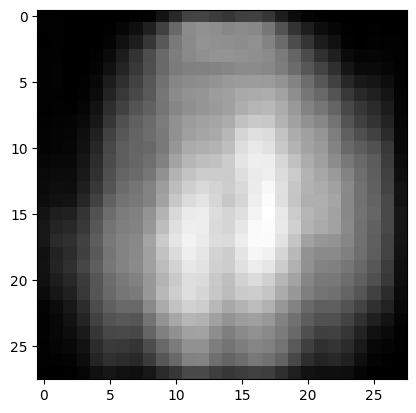

In [51]:
test_vector = torch.randn(1, model.latent_dim).to(device)
test_vector1 = torch.randn(1, model.latent_dim).to(device)

# decode the test_vector from the model
decoded_vector = model(test_vector)
decoded_vector1 = model(test_vector1)
# show the test_vector as a 28x28 image
import matplotlib.pyplot as plt
plt.imshow(decoded_vector.detach().cpu().numpy().reshape(28, 28), cmap='gray')
plt.show()

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]])


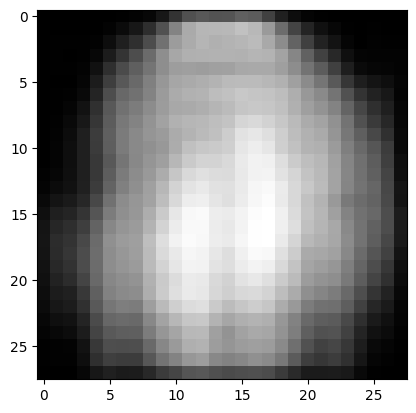

In [52]:
print(test_vector == test_vector1)
plt.imshow(decoded_vector1.detach().cpu().numpy().reshape(28, 28), cmap='gray')